# Car Price Prediction

In [371]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests
import re
import time
from datetime import date
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
%matplotlib inline

## Getting scraped data from csv file

In [346]:
df = pd.read_csv('data/car_info.csv', index_col=0)

In [347]:
df = df.dropna()

## Data cleaning

### Fuel type

In [348]:
def is_gas(row):
    regex1 = re.compile('.*Gas.*')
    regex2 = re.compile('.*Flex.*')
    if regex1.match(row.fuel_type) or \
    regex2.match(row.fuel_type) or \
    row.fuel_type == 'Hybrid ':
        return 1
    else:
        return 0
    
def is_diesel(row):
    regex1 = re.compile('Diesel.*')
    regex2 = re.compile('.*Flex Fuel.*')
    if regex1.match(row.fuel_type) or \
    regex2.match(row.fuel_type):
        return 1
    else:
        return 0
    
def is_electric(row):
    regex = re.compile('.*Electric.*')
    if regex.match(row.fuel_type) or \
    row.fuel_type == 'Hybrid ':
        return 1
    else:
        return 0

In [349]:
df['is_gas'] = df.apply(lambda row : is_gas(row), axis=1)
df['is_diesel'] = df.apply(lambda row : is_diesel(row), axis=1)
df['is_electric'] = df.apply(lambda row : is_electric(row), axis=1)

### Year

In [350]:
def get_year_make_model(row):
    i = row['name']
    w = i.split()
    return w

In [351]:
df['age'] = df.apply(lambda row : date.today().year - int(get_year_make_model(row)[0]), axis=1)\
    .astype('int')
df['make_model'] = df.apply(lambda row : get_year_make_model(row)[1] + get_year_make_model(row)[2], axis=1)
# df['model'] = df.apply(lambda row : get_year_make_model(row)[2], axis=1)

### MPG

In [352]:
# drop rows with blank mpg
df = df[df['mpg'] != '–']
df = df[df['mpg'] != 'None']

In [353]:
def get_low_mpg(row):
    i = row.mpg.find('–')
    if i != -1:
        return row.mpg[0:i]
    else:
        return row.mpg

def get_high_mpg(row):
    i = row.mpg.find('–')
    if i != -1:
        return row.mpg[i+1:]
    else:
        return 0

In [354]:
df['mpg'] = df.apply(lambda row : int(get_low_mpg(row)) + int(get_high_mpg(row)), axis=1).astype('int')

### Transmission

In [355]:
def is_auto(row):
    regex = re.compile('.*([A|a]uto|A/T|Dual Shift).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0

def is_cvt(row):
    regex = re.compile('.*(CVT|Variable).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0
    
def is_manual(row):
    regex = re.compile('.*(Manual|M/T).*')
    if regex.match(row.transmission):
        return 1
    else:
        return 0
    
def get_speed(row):
    tmp = row.transmission
    tmp = re.sub('[^0-9]', '', tmp)
    if tmp == '':
        return 0
    else:
        return int(tmp)

In [356]:
df['is_auto'] = df.apply(lambda row : is_auto(row), axis=1)
df['is_cvt'] = df.apply(lambda row : is_cvt(row), axis=1)
df['is_manual'] = df.apply(lambda row : is_manual(row), axis=1)
df['speed'] = df.apply(lambda row : get_speed(row), axis=1)

### Engine

In [357]:
def get_L(row):
    i = row.engine.find('L')
    if i == -1:
        return 0
    else:
        return float(row.engine[i-3:i])

def get_V(row):
    i = row.engine
    a = re.compile('.*16V.*')
    b = re.compile('.*24V.*')
    c = re.compile('.*32V.*')
    d = re.compile('.*48V.*')
    e = re.compile('.*12V.*')
    if a.match(i):
        return 16
    elif b.match(i):
        return 24
    elif c.match(i):
        return 32
    elif d.match(i):
        return 48
    elif e.match(i):
        return 12
    else:
        return 0

In [358]:
df['engine_L'] = df.apply(lambda row : get_L(row), axis=1).astype('float')
df['engine_V'] = df.apply(lambda row : get_V(row), axis=1).astype('float')

### Drivetrain

In [359]:
# drop rows with blank drivetrain
df.drivetrain = df.drivetrain.apply(lambda x : x[1:-1])
df = df[df['drivetrain'] != '–']

In [360]:
def get_drivetrain(row):
    i = row.drivetrain
    four = re.compile('.*(Front|Rear|FWD).*')
    two = re.compile('.*(All|Four|4WD|AWD).*')
    if four.match(i):
        return 4
    elif two.match(i):
        return 2
    else:
        return 0

In [361]:
df['drivetrain'] = df.apply(lambda row : get_drivetrain(row), axis=1)

## Car make and model

In [362]:
df = pd.get_dummies(df, columns=['make_model'], \
                    prefix='mm', prefix_sep='_')
df = pd.get_dummies(df, columns=['drivetrain'], \
                    prefix='dt', prefix_sep='_')

### Drop useless columns

In [363]:
df = df.drop(columns=\
             ['name', 'ex_color', 'in_color', \
              'mpg', 'fuel_type', 'transmission', 'engine'])

In [364]:
df

,index,price,mileage,is_gas,is_diesel,is_electric,age,is_auto,is_cvt,is_manual,...,mm_VolkswagenTaos,mm_VolkswagenTiguan,mm_VolvoS60,mm_VolvoS90,mm_VolvoV60,mm_VolvoV90,mm_VolvoXC60,mm_VolvoXC90,dt_2,dt_4
0,0,27995.0,29192,1,0,0,3,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,52458.0,56059,0,0,1,3,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,22115.0,15039,1,0,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,3,19500.0,61754,1,0,0,5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,34952.0,26577,1,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,15,44998.0,17090,1,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1191,16,18980.0,48959,1,0,0,2,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1192,17,17629.0,66881,1,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1193,18,82900.0,47936,0,0,1,5,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## Building regression model

## Virtualization

In [365]:
# plt.figure(dpi=100)
# sns.pairplot(df)

### Divide dataset

In [366]:
train_df, test_df = train_test_split(df, test_size=0.2)

### Fit model

In [367]:
X = train_df.drop(columns=['price'], axis=1)
y = train_df.price

model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.941016086887755

In [368]:
# test
X_test = test_df.drop(columns=['price'], axis=1)
y_test = test_df.price
model.score(X_test, y_test)

0.8692604446211484

In [369]:
test_df

,index,price,mileage,is_gas,is_diesel,is_electric,age,is_auto,is_cvt,is_manual,...,mm_VolkswagenTaos,mm_VolkswagenTiguan,mm_VolvoS60,mm_VolvoS90,mm_VolvoV60,mm_VolvoV90,mm_VolvoXC60,mm_VolvoXC90,dt_2,dt_4
1099,4,24560.0,17800,1,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1072,17,37610.0,86152,1,0,0,4,1,0,0,...,0,0,0,0,0,0,0,0,1,0
20,0,91500.0,14844,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
172,14,45991.0,16606,1,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
570,14,63895.0,14949,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,1,51999.0,11281,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
782,6,47994.0,21699,1,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
465,9,82977.0,16600,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1093,18,32498.0,17670,1,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1


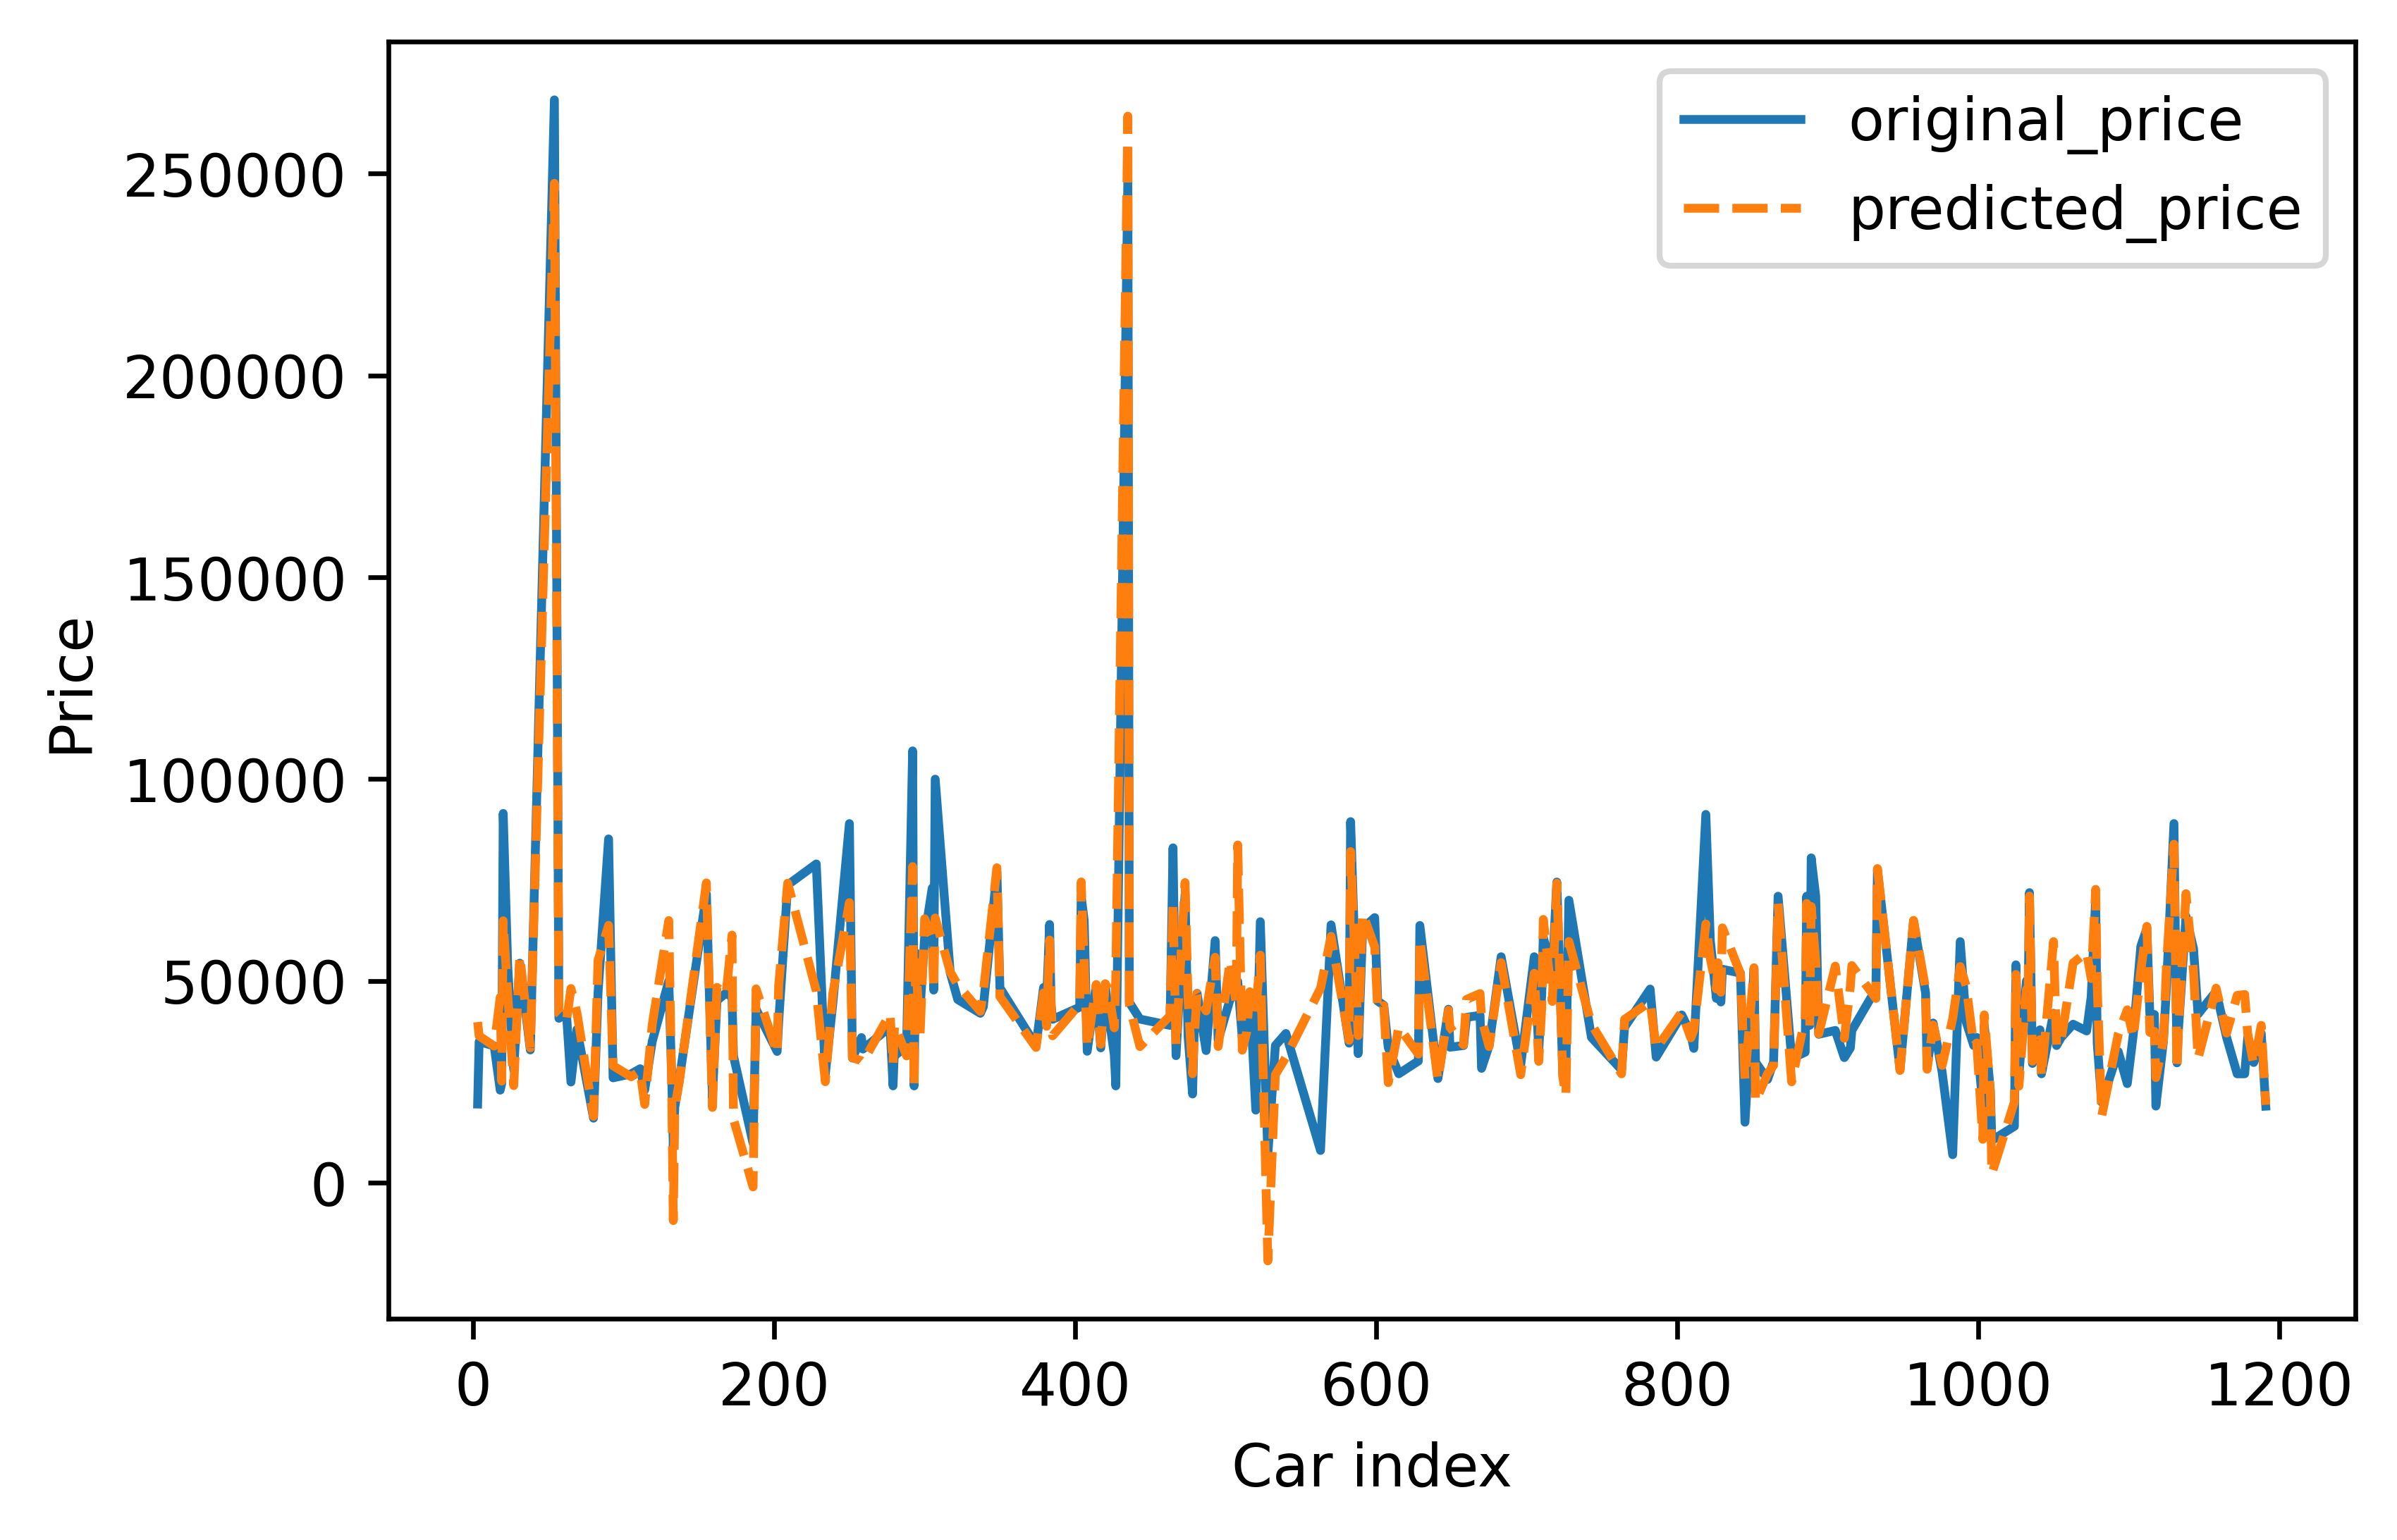

In [381]:
# model.predict(X_test)
plt.figure(dpi=600)
df_res = pd.DataFrame()
df_res['original_price'] = y_test
df_res['predicted_price'] = model.predict(X_test)
ax = sns.lineplot(data=df_res)
plt.xlabel('Car index')
plt.ylabel('Price')
plt.savefig('linear_regression_test.png')

In [373]:
# save the model
with open('models/linear_model_pkl', 'wb') as file:
    pickle.dump(model, file)

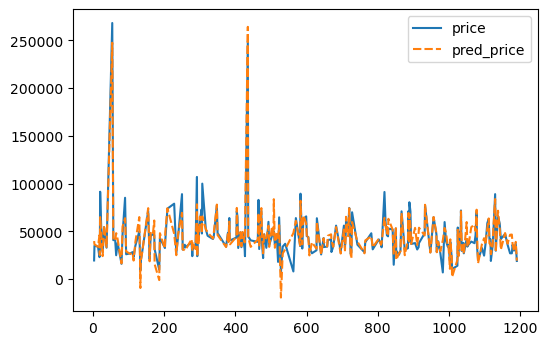

In [374]:
# load the model from pickle file
with open('models/linear_model_pkl', 'rb') as f:
    lr = pickle.load(f)

plt.figure(dpi=100)
df_res2 = pd.DataFrame()
df_res2['price'] = y_test
df_res2['pred_price'] = lr.predict(X_test)
ax2 = sns.lineplot(data=df_res2)